In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' is similar to Times New Roman
# If you want to use LaTeX to render all text (for more consistency)
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 0.5    # Axis line width
plt.rcParams['lines.linewidth'] = 1    # Line width
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['lines.markersize'] = 3
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
additional_colors = [
    '#191970',  # Midnight Blue
    (0.498, 1.0, 0.831),  # Aqua Marine
    '#228B22',  # Forest Green
    '#FF7F50',  # Coral
    (0.855, 0.647, 0.125),  # Golden Rod
    '#FF1493',  # Deep Pink
    (0.901, 0.901, 0.980),  # Lavender
    '#A0522D',  # Sienna
    (0.0, 0.501, 0.501),  # Teal
    '#DA70D6'   # Orchid
]

colors += additional_colors

In [3]:
# Number of time steps
nt = 12

# Number of testing data
num_data = 200

# Number of branches
num_branches = 186

# Significant branches
top_branch_idx = np.array([172,  53, 150,  37])

In [4]:
PTDF = pd.read_csv('../../data/IEEE_Case118/PTDF/PTDF_matrix.csv', header=None, index_col=None)

In [5]:
for i in range(num_data):
    PB_true = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PB/true_corr/true_corr_{i+1}.csv', header=None, index_col=None)
    PF_true = PTDF@PB_true
    PF_true.to_csv(f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv', index=None, header=None)

    PB_pred = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PB/pred_corr/pred_corr_{i+1}.csv', header=None, index_col=None)
    PF_pred = PTDF@PB_pred
    PF_pred.to_csv(f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv', index=None, header=None)

## Mean relative error

In [6]:
rela_err = np.zeros((num_data, num_branches, nt)) * np.nan

for i in range(num_data):
    # Read ground truth
    PF_true = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv', header=None, index_col=None).to_numpy()
    # Read prediction
    PF_pred = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv', header=None, index_col=None).to_numpy()

    # Get valid index (Set threshold to 1)
    idx = (PF_true != 0) & (PF_true >= 1)

    # Calculate relative error
    rela_err[i, idx] = np.abs((PF_true[idx] - PF_pred[idx]) / PF_true[idx])

In [7]:
MRE = np.nanmean(rela_err, axis=0)

/var/folders/cn/s2z4sz3n33n4m238vt6kj7j40000gn/T/ipykernel_9878/1903288037.py:1: RuntimeWarning: Mean of empty slice
  MRE = np.nanmean(rela_err, axis=0)


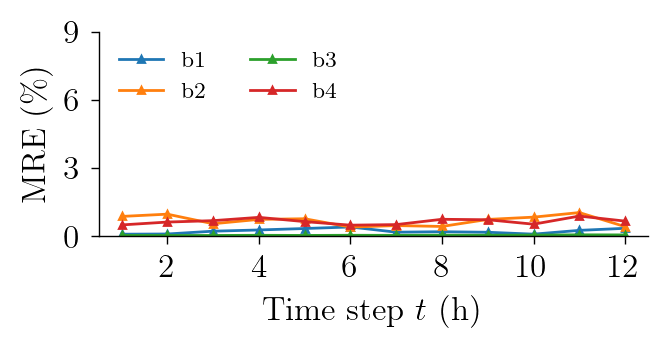

In [19]:
fig = plt.figure(figsize=(3.5, 1.9))

ax = fig.add_subplot(111)
ax.plot(np.arange(1, 13), MRE[top_branch_idx[0], :], color=colors[0], linewidth=1, marker='^', markersize=2, label='b1')
ax.plot(np.arange(1, 13), MRE[top_branch_idx[1], :], color=colors[1], linewidth=1, marker='^', markersize=2, label='b2')
ax.plot(np.arange(1, 13), MRE[top_branch_idx[2], :], color=colors[2], linewidth=1, marker='^', markersize=2, label='b3')
ax.plot(np.arange(1, 13), MRE[top_branch_idx[3], :], color=colors[3], linewidth=1, marker='^', markersize=2, label='b4')
ax.set_xlabel('Time step $t$ (h)')
ax.set_ylabel('MRE (\%)')
ax.set_xlim((0.5, 12.5))
ax.set_ylim(0, 9)
ax.set_xticks(np.arange(2, 13, 2))
ax.set_yticks(np.arange(0, 10, 3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=2, fontsize=8, frameon=False, loc="upper left")

plt.tight_layout()
plt.show()
# fig.savefig(f'../../submission/118_PF_MRE.png', bbox_inches='tight', dpi=300)
plt.close('all')

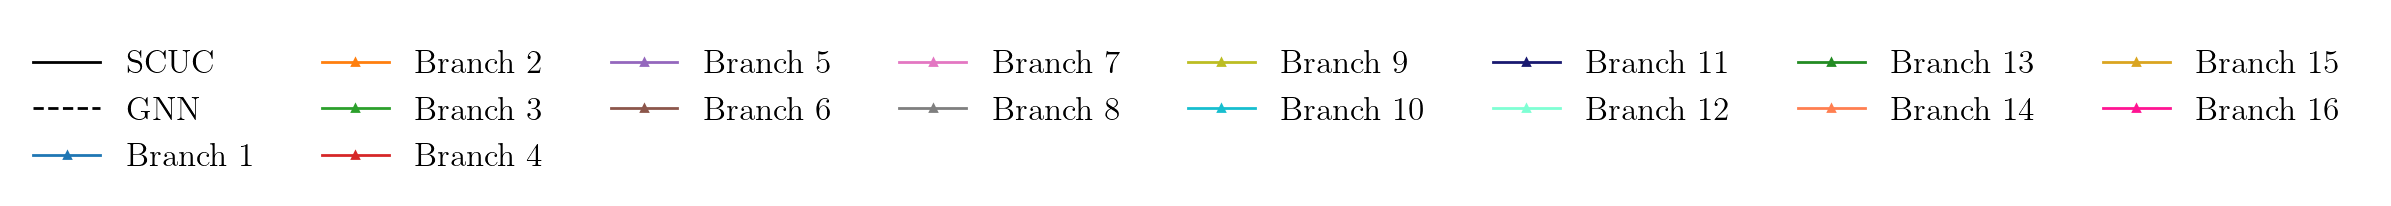

In [27]:
labels = [f"Branch {i}" for i in range(1, 17)]

# Create a figure with an estimated small size
fig, ax = plt.subplots(figsize=(1, 1))  # You may need to adjust these values

ax.plot([], [], color="black", label="SCUC")
ax.plot([], [], color="black", linestyle="--", label="GNN")

# Define plot elements for the legend (without plotting data)
# ax.plot([], [], marker='', label='System')
for i in range(16):
    ax.plot([], [], marker='^', markersize=2, color=colors[i], label=labels[i])

legend = ax.legend(frameon=False, ncols=8)

# Hide the axes
ax.axis('off')

# Now, adjust the figure size based on the legend
fig.canvas.draw()  # Draw the canvas to get the legend size
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.set_size_inches(bbox.width, bbox.height)

# Optionally, save the figure
# plt.savefig('legend_only.png', bbox_inches='tight')

# plt.tight_layout()
plt.show()